In [1]:
from importlib import reload
from src import data_setup, engine, models, utils
[reload(module) for module in [data_setup, engine, models, utils]]; # During Development

In [2]:
# Verify installation and initialize computing device
device = engine.initialize()

[CONNECTED] NVIDIA GeForce RTX 3070


In [3]:
# Verify/Download image dataset(s) from a zip file(s)
url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip'
data_path = data_setup.download_data('data', url=url, dataset_name='PSS_0.2')

[INFO] Did not find 'data\PSS_0.2' directory. Creating one:
[INFO] Downloading 'PSS_0.2' dataset from 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip':
Total size = 30.03 MiB


100%|██████████| 31/31 [00:02<00:00, 14.92MiB/s]


[INFO] Extracting 'data\PSS_0.2\data_file.zip' .. done.


In [4]:
from torchvision.models import \
    EfficientNet_B1_Weights as EB1w, \
    efficientnet_b1 as EB1

from torchvision.transforms import TrivialAugmentWide, Compose
from os import cpu_count

# Same transformation used for imported pretrained weights
auto_transform = EB1w.DEFAULT.transforms()

# DataLoaders configurations
directories = [data_path/subset for subset in ('train', 'test')]
transforms = [Compose([TrivialAugmentWide(), auto_transform]), auto_transform]
splits = [(0.8, 0.2), None]
shuffles = [True, False]
batch_size = 32

train_loader, val_loader, test_loader, classes = data_setup.create_dataloaders(
    directories=directories, transforms=transforms, splits=splits, shuffles=shuffles,
    batch_size=batch_size, num_workers=cpu_count()//6, device=device
)

Loader#0: 384 samples
Loader#1: 96 samples
Loader#2: 160 samples
Target: ['pizza', 'steak', 'sushi']


In [5]:
# Getting the data transformation size (optional)
size = [auto_transform.resize_size[0]]*2

# Modifying the pretrained model's head and freezing the rest
pre_trained_model = EB1(weights=EB1w.DEFAULT)
model = models.fine_tune_on_classes(pre_trained_model, target=classes, device=device, input_size=size)
model.summary()

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [1, 3, 255, 255]     [1, 3]               --                   Partial
├─Sequential: 1-1                                       [1, 3, 255, 255]     [1, 1280, 8, 8]      --                   False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 255, 255]     [1, 32, 128, 128]    --                   False
│    │    └─Conv2d: 3-1                                 [1, 3, 255, 255]     [1, 32, 128, 128]    (864)                False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]    [1, 32, 128, 128]    (64)                 False
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]    [1, 32, 128, 128]    --                   --
│    └─Sequential: 2-2                                  [1, 32, 128, 128]    [1, 16, 128, 128]    --                   Fal

In [6]:
# Clear potential zombie processes
engine.clear_processes()

# Training engine for a classification problem
trainer = engine.ClassTrainer(model)

trainer.run(train_loader, val_loader, epochs=50, model_name='EffNetB1_50e')

[INFO] Initializing Tensorboard for:
	runs\2023-06-07_Evaar\00-45-14\EffNetB1_50e
[INFO] Initializing Training Process - First Evaluation
[INFO] Training Started.
--------------------
[01] ###### [100.0%] | train: l=1.02, a=063.33% [0.02/1.58s] | val: l=0.93, a=076.67% | lr=0.001000
[02] ###### [100.0%] | train: l=0.85, a=081.67% [0.02/1.57s] | val: l=0.81, a=078.89% | lr=0.000975
[03] ###### [100.0%] | train: l=0.74, a=085.56% [0.02/1.53s] | val: l=0.71, a=084.44% | lr=0.000951
[04] ###### [100.0%] | train: l=0.63, a=088.33% [0.02/1.54s] | val: l=0.65, a=082.22% | lr=0.000927
[05] ###### [100.0%] | train: l=0.58, a=087.50% [0.02/1.54s] | val: l=0.59, a=090.00% | lr=0.000904
[06] ###### [100.0%] | train: l=0.55, a=086.67% [0.02/1.54s] | val: l=0.58, a=082.22% | lr=0.000881
[07] ###### [100.0%] | train: l=0.50, a=090.00% [0.02/1.53s] | val: l=0.53, a=091.11% | lr=0.000859
[08] ###### [100.0%] | train: l=0.45, a=093.06% [0.02/1.58s] | val: l=0.47, a=090.00% | lr=0.000838
[09] ###### [100

'2023-06-07_Evaar'

In [7]:
trainer.evaluate(test_loader, classes)
trainer.writer.close()

[100.0%]

Shutting down workers at [22488, 20680]
Mean Average Values:
--------------------
Loss		0.2230
Acc			0.9467
Precision	0.9467
Recall		0.9450
F1 Score	0.9454
AUC			0.9936


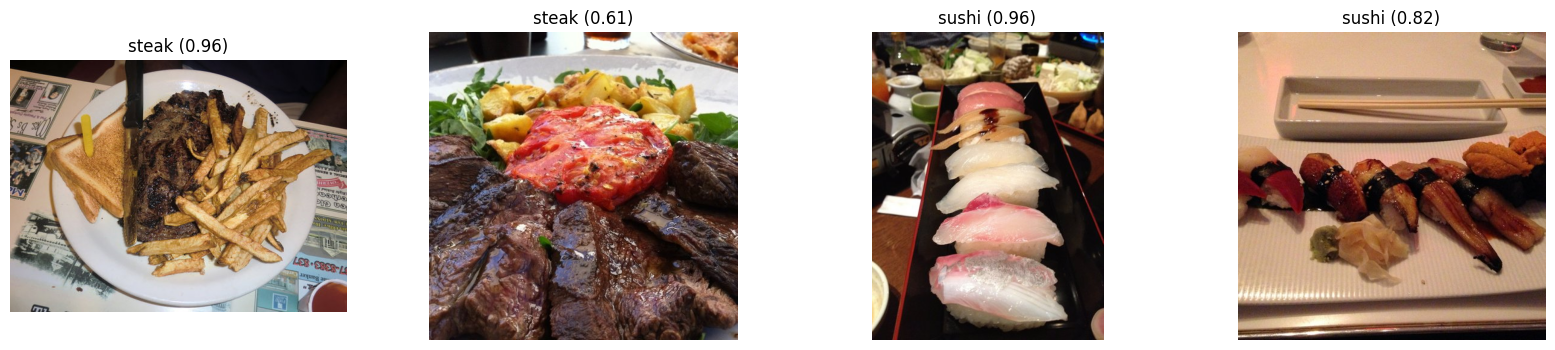

In [8]:
engine.inference(model, data_path/'test', classes, transform=auto_transform, device=device, n=4)

# Experiments

In [9]:
from torchvision.models import efficientnet_b0 as b0, efficientnet_b1 as b1, EfficientNet_B0_Weights as b0w, EfficientNet_B1_Weights as b1w

w = utils.ExpWrapper

models = [w((b0, b0w.DEFAULT), 'EffNetB0'), w((b1, b1w.DEFAULT), 'EffNetB1')]

url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'
dataset_1 = w(data_setup.download_data('data', url, 'PSS_0.1'), 'PSS_0.1')

url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip'
dataset_2 = w(data_setup.download_data('data', url, 'PSS_0.2'), 'PSS_0.1')

experiment_space = {
    'model':        models,
    'data':         [dataset_1, dataset_2],
    'epochs':       [5, 10],
    'dropout':      [0.1, 0.2, 0.3],
}

experiments = utils.prepare_experiments(experiment_space)
experiments

[INFO] Did not find 'data\PSS_0.1' directory. Creating one:
[INFO] Downloading 'PSS_0.1' dataset from 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip':
Total size = 15.01 MiB


100%|██████████| 16/16 [00:01<00:00, 14.20MiB/s]


[INFO] Extracting 'data\PSS_0.1\data_file.zip' .. done.
[INFO] 'PSS_0.2' dataset already exist. Download skipped.


[{'model': EffNetB0, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.1},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.2},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.3},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 10, 'dropout': 0.1},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 10, 'dropout': 0.2},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 10, 'dropout': 0.3},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.1},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.2},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.3},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 10, 'dropout': 0.1},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 10, 'dropout': 0.2},
 {'model': EffNetB0, 'data': PSS_0.1, 'epochs': 10, 'dropout': 0.3},
 {'model': EffNetB1, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.1},
 {'model': EffNetB1, 'data': PSS_0.1, 'epochs': 5, 'dropout': 0.2},
 {'model': EffNetB1, 'data': PSS_0.1, 'epo

In [10]:
engine.start_experiments(experiments)

[CONNECTED] NVIDIA GeForce RTX 3070



[INFO] Configurating Exp_00
Loader#0: 192 samples
Loader#1: 64 samples
Loader#2: 96 samples
Target: ['pizza', 'steak', 'sushi']
[INFO] Starting Exp_00
[INFO] Initializing Tensorboard for:
	runs\2023-06-07_Evaar\automated_experiment_00_47_13\Exp_00
[INFO] Initializing Training Process - First Evaluation
[INFO] Training Started.
--------------------
[1] ###### [100.0%] | train: l=1.08, a=040.00% [0.03/1.11s] | val: l=0.94, a=064.44% | lr=0.001000
[2] ###### [100.0%] | train: l=0.92, a=061.67% [0.02/0.77s] | val: l=0.79, a=084.44% | lr=0.000975
[3] ###### [100.0%] | train: l=0.79, a=076.11% [0.02/0.71s] | val: l=0.68, a=086.67% | lr=0.000951
[4] ###### [100.0%] | train: l=0.69, a=086.67% [0.02/0.65s] | val: l=0.57, a=095.56% | lr=0.000927
[5] ###### [100.0%] | train: l=0.62, a=086.67% [0.02/0.68s] | val: l=0.59, a=091.11% | lr=0.000904
--------------------
[INFO] Training Completed.
	Total time = 5.51s
Shutting down workers at [26216, 24484, 22404]
S